In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

## Prepare data

In [2]:
# Define the data to be used
DATASET = "../../datasets/dataset_uncertainty_indoor/"
# DATASET = "../../datasets/dataset_3+8bags_3var3sc_regression_classification_kmeans_split/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [3]:
def compute_mean_std(images_directory, traversal_costs_file):
    """Compute the mean and standard deviation of the dataset

    Args:
        images_directory (string): Directory with all the images
        traversal_costs_file (string): Name of the csv file which contains
        images index and their associated traversal cost

    Returns:
        torch::Tensor: Mean and standard deviation of the dataset
    """
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [4]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3428, 0.3571, 0.2912]) tensor([0.1364, 0.1248, 0.1303])


In [5]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225]
        mean=mean,
        std=std
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225]
        mean=mean,
        std=std
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [6]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [7]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

69.0 % of the data for training (6238 samples)
15.0 % of the data for validation (1337 samples)
17.0 % of the data for testing (1497 samples)


In [8]:
print(len(train_loader.dataset))

6238


## GPU?

In [9]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [10]:
def resnet18(device=device):
    """Create a ResNet18 model with a fully-connected layer at the end.

    Args:
        device (string, optional): The device to use. Defaults to device.

    Returns:
        Model: The ResNet18 model
    """
    # Load the pre-trained ResNet model
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device=device)

    # Replace the last layer by a fully-connected one with N outputs
    # (N being the number of classes)
    resnet.fc = nn.Linear(resnet.fc.in_features, 10, device=device)

    # Initialize the last layer using Xavier initialization
    nn.init.xavier_uniform_(resnet.fc.weight)
    
    return resnet

In [11]:
# Create a ResNet18 model
model = resnet18()

#### Visualize the model

In [12]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels = next(iter(train_loader))
images = images.to(device)
tensorboard.add_graph(model, images)

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

[('conv1.weight', torch.Size([64, 3, 7, 7])), ('bn1.weight', torch.Size([64])), ('bn1.bias', torch.Size([64])), ('layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])), ('layer1.0.bn1.weight', torch.Size([64])), ('layer1.0.bn1.bias', torch.Size([64])), ('layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])), ('layer1.0.bn2.weight', torch.Size([64])), ('layer1.0.bn2.bias', torch.Size([64])), ('layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])), ('layer1.1.bn1.weight', torch.Size([64])), ('layer1.1.bn1.bias', torch.Size([64])), ('layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])), ('layer1.1.bn2.weight', torch.Size([64])), ('layer1.1.bn2.bias', torch.Size([64])), ('layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])), ('layer2.0.bn1.weight', torch.Size([128])), ('layer2.0.bn1.bias', torch.Size([128])), ('layer2.0.conv2.weight', torch.Size([128, 128, 3, 3])), ('layer2.0.bn2.weight', torch.Size([128])), ('layer2.0.bn2.bias', torch.Size([128])), ('layer2.0.downsample.0.weight', torch.Size([12

## Training and validation loops

In [15]:
def train(model, device, train_loader, optimizer, criterion_classification, criterion_regression, bins_midpoints, epoch):
    """Train the model for one epoch

    Args:
        model (Model): The model to train
        device (string): The device to use (cpu or cuda)
        train_loader (Dataloader): The training data loader
        optimizer (Optimizer): The optimizer to use
        criterion_classification (Loss): The classification loss to use
        criterion_regression (Loss): The regression loss to use
        bins_midpoints (ndarray): The midpoints of the bins used to discretize the traversal costs
        epoch (int): The current epoch

    Returns:
        double, double, double: The training loss, the training accuracy and the training regression loss
    """
    # Initialize the training loss and accuracy
    train_loss = 0.
    train_correct = 0
    train_regression_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, traversability_labels in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        traversability_labels = traversability_labels.to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversability_labels = model(images)
        # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))
        
        # Compute loss 
        loss = criterion_classification(predicted_traversability_labels, traversability_labels)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
        # Get the number of correct predictions
        train_correct += torch.sum(
            torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
            ).item()
        
        # Compute the expected traversal cost over the bins
        expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)
        
        # Compute and accumulate the batch loss
        train_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
    
    # Compute the losses and accuracies
    train_loss /= len(train_loader)
    train_accuracy = 100*train_correct/NB_TRAIN
    train_regression_loss /= len(train_loader)
        
    return train_loss, train_accuracy, train_regression_loss

In [16]:
def validate(model, device, val_loader, criterion_classification, criterion_regression, bins_midpoints, epoch):
    """Validate the model for one epoch

    Args:
        model (Model): The model to validate
        device (string): The device to use (cpu or cuda)
        val_loader (Dataloader): The validation data loader
        criterion_classification (Loss): The classification loss to use
        criterion_regression (Loss): The regression loss to use
        bins_midpoints (ndarray): The midpoints of the bins used to discretize the traversal costs
        epoch (int): The current epoch
        
    Returns:
        double, double, double: The validation loss, the validation accuracy and the validation regression loss
    """
    # Initialize the validation loss and accuracy
    val_loss = 0.
    val_correct = 0
    val_regression_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, traversability_labels in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversability_labels = model(images)
            # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)

            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
            # Get the number of correct predictions
            val_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)

            # Compute and accumulate the batch loss
            val_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
        
    # Compute the losses and accuracies
    val_loss /= len(val_loader)
    val_accuracy = 100*val_correct/NB_VAL
    val_regression_loss /= len(val_loader)
    
    return val_loss, val_accuracy, val_regression_loss

In [17]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None], dtype=torch.float32, device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["fc.weight", "fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.fc.parameters(), "lr": 1e-3},
],
    lr=1e-4, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 40

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, NB_EPOCHS)
accuracy_values = torch.zeros(2, NB_EPOCHS)
regression_loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    # Add the accuracies to TensorBoard
    tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
    tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
    # Add the regression losses to TensorBoard
    tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
    tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.13batch/s, batch_loss=2.18]


Train accuracy:  25.585123436999037
Validation accuracy:  28.571428571428573
Train regression loss:  0.07012841990583364
Validation regression loss:  0.057840216399178836


Epoch 1 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.28batch/s, batch_loss=1.88]


Train accuracy:  30.282141712087206
Validation accuracy:  28.646222887060585
Train regression loss:  0.04904899146072412
Validation regression loss:  0.05437940774861768


Epoch 2 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.15batch/s, batch_loss=1.8] 


Train accuracy:  32.334081436357806
Validation accuracy:  29.842931937172775
Train regression loss:  0.047150295032673976
Validation regression loss:  0.05466873218148336


Epoch 3 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.46batch/s, batch_loss=1.8] 


Train accuracy:  33.10355883295928
Validation accuracy:  29.319371727748692
Train regression loss:  0.04450305247908575
Validation regression loss:  0.05585646644359664


Epoch 4 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.15batch/s, batch_loss=1.41]


Train accuracy:  34.46617505610773
Validation accuracy:  29.094988780852656
Train regression loss:  0.04427361276451033
Validation regression loss:  0.050521856406251286


Epoch 5 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.10batch/s, batch_loss=1.93]


Train accuracy:  35.37992946457198
Validation accuracy:  29.69334330590875
Train regression loss:  0.0417535072081079
Validation regression loss:  0.04757851542381157


Epoch 6 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.09batch/s, batch_loss=1.61]


Train accuracy:  35.29977556909266
Validation accuracy:  32.460732984293195
Train regression loss:  0.041628545714876716
Validation regression loss:  0.04743451618413151


Epoch 7 [val]: 100%|██████████| 42/42 [00:01<00:00, 30.76batch/s, batch_loss=1.49]


Train accuracy:  36.117345302981725
Validation accuracy:  29.319371727748692
Train regression loss:  0.040652416415772205
Validation regression loss:  0.04619493371631981


Epoch 8 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.98batch/s, batch_loss=1.78]


Train accuracy:  36.29368387303623
Validation accuracy:  30.964846671652953
Train regression loss:  0.040763153622192703
Validation regression loss:  0.048921161424803156


Epoch 9 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.10batch/s, batch_loss=1.45]


Train accuracy:  36.91888425777493
Validation accuracy:  33.05908750934929
Train regression loss:  0.0396618282659916
Validation regression loss:  0.04647826704210961


Epoch 10 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.97batch/s, batch_loss=1.26]


Train accuracy:  38.05706957358127
Validation accuracy:  31.787584143605088
Train regression loss:  0.0394053824239096
Validation regression loss:  0.04865360154376025


Epoch 11 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.63batch/s, batch_loss=1.98]


Train accuracy:  38.69830073741584
Validation accuracy:  32.01196709050112
Train regression loss:  0.03807505852067682
Validation regression loss:  0.0502673045964923


Epoch 12 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.70batch/s, batch_loss=1.9] 


Train accuracy:  38.77845463289516
Validation accuracy:  33.7322363500374
Train regression loss:  0.038559727283386774
Validation regression loss:  0.046033878499260855


Epoch 13 [val]: 100%|██████████| 42/42 [00:01<00:00, 29.57batch/s, batch_loss=1.89]


Train accuracy:  39.820455274126324
Validation accuracy:  33.43305908750935
Train regression loss:  0.03645095363247811
Validation regression loss:  0.04586283583268752


Epoch 14 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.81batch/s, batch_loss=1.46]


Train accuracy:  40.50977877524848
Validation accuracy:  33.283470456245325
Train regression loss:  0.03707919478153521
Validation regression loss:  0.04789549131718336


Epoch 15 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.39batch/s, batch_loss=1.69]


Train accuracy:  41.47162552100032
Validation accuracy:  33.43305908750935
Train regression loss:  0.03687258265821459
Validation regression loss:  0.044036002488151316


Epoch 16 [val]: 100%|██████████| 42/42 [00:01<00:00, 30.74batch/s, batch_loss=1.47]


Train accuracy:  41.03879448541199
Validation accuracy:  33.657442034405385
Train regression loss:  0.03757520611621887
Validation regression loss:  0.043079058023402866


Epoch 17 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.29batch/s, batch_loss=1.57]


Train accuracy:  41.08688682269958
Validation accuracy:  35.45250560957367
Train regression loss:  0.0357585066267945
Validation regression loss:  0.04169812194912906


Epoch 18 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.69batch/s, batch_loss=1.8] 


Train accuracy:  41.808271882013464
Validation accuracy:  31.114435302916977
Train regression loss:  0.03516438370241736
Validation regression loss:  0.04873385012522537


Epoch 19 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.52batch/s, batch_loss=1.43]


Train accuracy:  41.7922411029176
Validation accuracy:  32.086761406133135
Train regression loss:  0.03507311172972862
Validation regression loss:  0.04541185208984285


Epoch 20 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.62batch/s, batch_loss=1.97]


Train accuracy:  42.1930105803142
Validation accuracy:  28.122662677636498
Train regression loss:  0.034191313250394234
Validation regression loss:  0.04846927660538135


Epoch 21 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.09batch/s, batch_loss=1.66]


Train accuracy:  42.51362616223148
Validation accuracy:  33.20867614061331
Train regression loss:  0.03477289478053384
Validation regression loss:  0.04252474937742299


Epoch 22 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.24batch/s, batch_loss=1.42]


Train accuracy:  44.084642513626164
Validation accuracy:  34.62976813762154
Train regression loss:  0.03394162778251789
Validation regression loss:  0.04305852665821698


Epoch 23 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.63batch/s, batch_loss=2.05]


Train accuracy:  43.18691888425778
Validation accuracy:  33.7322363500374
Train regression loss:  0.03471728203398509
Validation regression loss:  0.04292253416407166


Epoch 24 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.71batch/s, batch_loss=1.6] 


Train accuracy:  45.046489259378006
Validation accuracy:  33.657442034405385
Train regression loss:  0.0338275570373965
Validation regression loss:  0.0440328090070186


Epoch 25 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.28batch/s, batch_loss=1.68]


Train accuracy:  46.42513626162231
Validation accuracy:  35.602094240837694
Train regression loss:  0.03220922359005141
Validation regression loss:  0.044983755129868616


Epoch 26 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.87batch/s, batch_loss=1.42]


Train accuracy:  45.960243667842256
Validation accuracy:  33.1338818249813
Train regression loss:  0.0318186143148471
Validation regression loss:  0.04611681675431011


Epoch 27 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.83batch/s, batch_loss=1.71]


Train accuracy:  46.08848990060917
Validation accuracy:  31.039640987284965
Train regression loss:  0.03285554600070736
Validation regression loss:  0.048485627499077255


Epoch 28 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.60batch/s, batch_loss=1.9] 


Train accuracy:  46.906059634498234
Validation accuracy:  34.031413612565444
Train regression loss:  0.03208557136026699
Validation regression loss:  0.0464452457252067


Epoch 29 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.16batch/s, batch_loss=1.86]


Train accuracy:  47.73966014748317
Validation accuracy:  35.228122662677634
Train regression loss:  0.030883634759105737
Validation regression loss:  0.04185608732733947


Epoch 30 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.91batch/s, batch_loss=1.36]


Train accuracy:  48.36486053222187
Validation accuracy:  36.49962602842184
Train regression loss:  0.030874386678175852
Validation regression loss:  0.040507706410626294


Epoch 31 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.47batch/s, batch_loss=1.9] 


Train accuracy:  49.61526130169926
Validation accuracy:  36.050860134629765
Train regression loss:  0.030084496019478716
Validation regression loss:  0.04178174522587171


Epoch 32 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.08batch/s, batch_loss=2.19]


Train accuracy:  49.43892273164476
Validation accuracy:  35.90127150336574
Train regression loss:  0.030396752970182954
Validation regression loss:  0.039841469731237755


Epoch 33 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.48batch/s, batch_loss=1.69]


Train accuracy:  48.92593780057711
Validation accuracy:  33.20867614061331
Train regression loss:  0.03051154101234489
Validation regression loss:  0.0448516357306822


Epoch 34 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.47batch/s, batch_loss=1.85]


Train accuracy:  50.51298493106765
Validation accuracy:  33.50785340314136
Train regression loss:  0.029758214022667068
Validation regression loss:  0.04103305363286031


Epoch 35 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.19batch/s, batch_loss=1.57]


Train accuracy:  51.0259698621353
Validation accuracy:  35.302916978309646
Train regression loss:  0.029759937518239805
Validation regression loss:  0.04032994096382475


Epoch 36 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.57batch/s, batch_loss=1.48]


Train accuracy:  50.48092337287592
Validation accuracy:  34.18100224382947
Train regression loss:  0.029638192174720634
Validation regression loss:  0.042982595929375714


Epoch 37 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.27batch/s, batch_loss=1.65]


Train accuracy:  51.63513946777813
Validation accuracy:  36.050860134629765
Train regression loss:  0.0292871597800497
Validation regression loss:  0.042120789638539186


Epoch 38 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.68batch/s, batch_loss=1.74]


Train accuracy:  52.03590894517473
Validation accuracy:  35.97606581899775
Train regression loss:  0.029150245052007924
Validation regression loss:  0.04047884096810359


Epoch 39 [val]: 100%|██████████| 42/42 [00:01<00:00, 30.60batch/s, batch_loss=1.43]

Train accuracy:  52.6771401090093
Validation accuracy:  36.20044876589379
Train regression loss:  0.02904422386924557
Validation regression loss:  0.041801678934341134


### Visualization

Text(0.5, 0, 'Epoch')

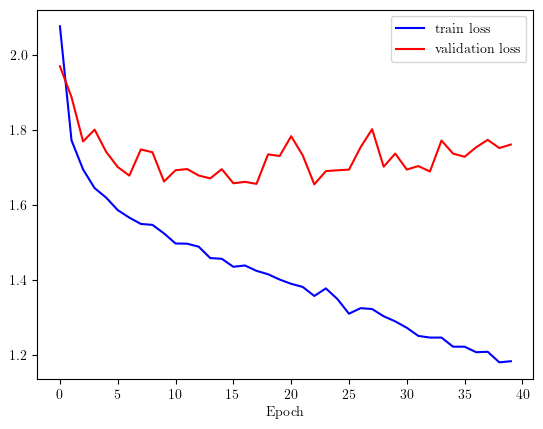

In [18]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

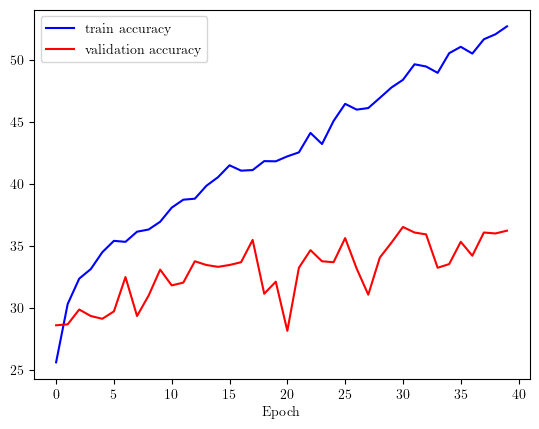

In [19]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

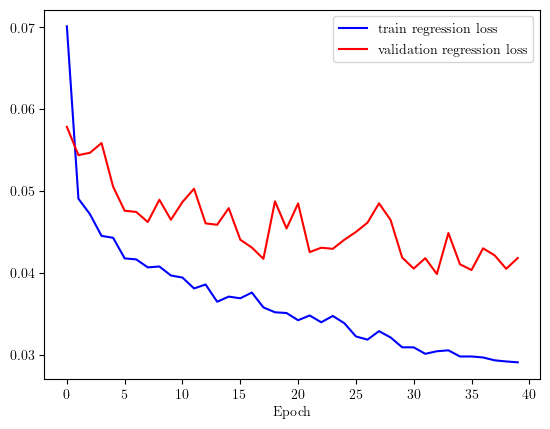

In [20]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Uncertainty functions

In [21]:
def shannon_entropy(p):
    """
    Apply the Shannon entropy function to a probability distribution
    """
    return -torch.sum(p*torch.log(p), dim=1)

def least_confidence(p):
    """
    Apply the least confidence function to a probability distribution
    """
    return 1 - torch.max(p, dim=1)[0]

def confidence_margin(p):
    """
    Apply the margin sampling function to a probability distribution
    """
    sorted_p, _ = torch.sort(p, dim=1, descending=True)
    return 1 - (sorted_p[:, 0] - sorted_p[:, 1])


#### Regression error function

In [22]:
def squared_error(predicted_costs, true_costs):
    """
    Apply the squared error function to a predicted and true traversal cost
    """
    return (predicted_costs - true_costs)**2

#### Test function

In [23]:
def test(model, device, test_loader, criterion_classification, criterion_regression, bins_midpoints, uncertainty_function):
    """Test the model on the test set

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        test_loader (Dataloader): The dataloader for the test set
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty

    Returns:
        double, double, double, list, list: The average loss, the accuracy, the regression loss,
        the list of the uncertainties, the list of regression losses
    """
    # Testing
    test_loss = 0.
    test_correct = 0
    test_regression_loss = 0.

    # Configure the model for testing
    model.eval()

    test_regression_losses = []
    uncertainties = []

    with torch.no_grad():
        # Loop over the testing batches
        for images, traversal_costs, traversability_labels in test_loader:

            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)

            # Perform forward pass
            predicted_traversability_labels = model(images)

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)
            
            # Accumulate batch loss to average of the entire testing set
            test_loss += loss.item()

            # Get the number of correct predictions
            test_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()

            # Apply the softmax function to the predicted traversability labels
            probabilities = nn.Softmax(dim=1)(predicted_traversability_labels)

            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(probabilities, bins_midpoints)
            
            # Compute and accumulate the batch loss
            test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()

            # Compute the loss for each sample
            test_regression_losses.append(squared_error(expected_traversal_costs[:, 0], traversal_costs).to("cpu"))
            
            # Compute the uncertainty
            uncertainties.append(uncertainty_function(probabilities).to("cpu"))

    # Compute the loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100*test_correct/NB_TEST
    
    # Compute the regression loss
    test_regression_loss /= len(test_loader)
   
    return test_loss, test_accuracy, test_regression_loss, test_regression_losses, uncertainties

#### Testing the model

In [24]:
# Set the uncertainty function
uncertainty_function = shannon_entropy

# Test the model
_, test_accuracy, test_regression_loss, test_regression_losses, uncertainties = test(model,
                                                                                     device,
                                                                                     test_loader,
                                                                                     criterion_classification,
                                                                                     criterion_regression,
                                                                                     bins_midpoints,
                                                                                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  32.197728790915164
Regression loss:  0.06635485480938648


## Save model parameters

In [25]:
# Save the model parameters
# torch.save(model.state_dict(), "resnet18_.params")

## Assessing the relevance of the uncertainty

In [26]:
def uncertainty_relevance(model,
                          device,
                          criterion_classification,
                          criterion_regression,
                          bins_midpoints,
                          uncertainty_function,
                          test_set,
                          test_regression_loss,
                          test_regression_losses,
                          uncertainties,
                          nb_samples=len(test_set)):
    """Compute the regression losses after successive removal of the samples with the highest loss and uncertainty

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty
        test_set (Dataset): The test set
        test_regression_loss (double): The regression loss on the test set
        test_regression_losses (list): The list of the regression losses for each sample
        uncertainties (list): The list of the uncertainties for each sample
        nb_samples (int, optional): The number of samples in the test set. Defaults to len(test_set).

    Returns:
        list, list: The list of the regression losses after successive removal of the samples with the highest loss,
        the list of the regression losses after successive removal of the samples with the highest uncertainty
    """
    # Create lists to store the test losses
    test_losses_loss = [test_regression_loss]
    test_losses_uncertainty = [test_regression_loss]
    
    # Concatenate the regression losses and convert to numpy array
    test_regression_losses = torch.cat(test_regression_losses, dim=0).numpy()

    # Concatenate the uncertainties and convert to numpy array
    uncertainties = torch.cat(uncertainties, dim=0).numpy()

    # Loop over the different percentages of samples to keep
    for i in range(1, 10):

        # Calculate the number of samples to keep
        nb_samples_to_keep = int((1 - i*0.1)*nb_samples)
        # Calculate the indices of the samples with the lowest losses
        indices_to_keep_loss = test_regression_losses.argsort()[:nb_samples_to_keep]
        # Calculate the indices of the samples with the lowest uncertainties
        indices_to_keep_uncertainty = uncertainties.argsort()[:nb_samples_to_keep]
        
        if i == 1:
            test_set_display = Subset(test_set, indices=uncertainties.argsort()[nb_samples_to_keep:])
            
            for tensor, tcost, tclass in test_set_display:
                # De-normalize the normalized tensor
                tensor_denormalized = transforms.Compose([
                    transforms.Normalize(
                        mean=[0., 0., 0.],
                        std=1/std
                        ),
                    transforms.Normalize(
                        mean=-mean,
                        std=[1., 1., 1.]
                        ),
                    ])(tensor)

                # Convert the tensor to a PIL Image
                image_denormalized = transforms.ToPILImage()(tensor_denormalized)
                
                plt.imshow(image_denormalized)
                plt.title("De-normalized image")
                
                # print(type(image))
                # image = image.numpy().transpose(1, 2, 0)
                
                # cv2.imshow("Image", image)
                # cv2.waitKey()

        # Create a new test dataset without the samples with the largest losses
        test_set_loss = Subset(test_set, indices=indices_to_keep_loss)
        # Create a new test dataset without the samples with the largest uncertainties
        test_set_uncertainty = Subset(test_set, indices=indices_to_keep_uncertainty)

        # Create a new test dataloader without the samples with the largest losses
        test_loader_loss = DataLoader(test_set_loss,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=12,
                                      pin_memory=True,
                                      )
        # Create a new test dataloader without the samples with the largest uncertainties
        test_loader_uncertainty = DataLoader(test_set_uncertainty,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=12,
                                             pin_memory=True,
                                             )

        # Test the model on the new test dataset without the samples with the largest losses
        test_regression_loss_loss = test(model, 
                                         device,
                                         test_loader_loss,
                                         criterion_classification,
                                         criterion_regression,
                                         bins_midpoints,
                                         uncertainty_function)[2]
        # Test the model on the new test dataset without the samples with the largest uncertainties
        test_regression_loss_uncertainty = test(model,
                                                device,
                                                test_loader_uncertainty,
                                                criterion_classification,
                                                criterion_regression,
                                                bins_midpoints,
                                                uncertainty_function)[2]

        # Append the test loss to the list
        test_losses_loss.append(test_regression_loss_loss)
        test_losses_uncertainty.append(test_regression_loss_uncertainty)
        
    return test_losses_loss, test_losses_uncertainty

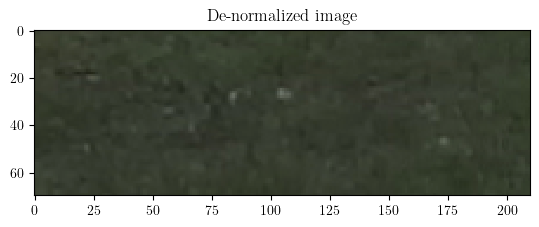

In [27]:
# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = uncertainty_relevance(model,
                                                                  device,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  uncertainty_function,
                                                                  test_set,
                                                                  test_regression_loss,
                                                                  test_regression_losses,
                                                                  uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

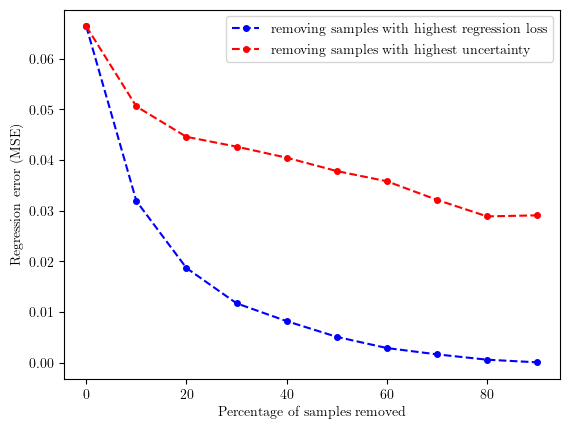

In [28]:
plt.plot(range(0, 100, 10), test_losses_loss, "bo--", label="removing samples with highest regression loss", markersize=4)
plt.plot(range(0, 100, 10), test_losses_uncertainty, "ro--", label="removing samples with highest uncertainty", markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

### Ensemble learning

#### Training the models

In [38]:
# Create a list of models
nb_models = 3
some_models = [resnet18() for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["fc.weight", "fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].fc.parameters(), "lr": 1e-3},
    ],
        lr=1e-4, momentum=0.9, weight_decay=0.001)
    
    # Loop over the epochs
    for epoch in range(NB_EPOCHS):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

Training model 1/3


Epoch 39 [train]: 100%|██████████| 195/195 [00:06<00:00, 28.92batch/s, batch_loss=1.66] 


Training model 2/3


Epoch 39 [train]: 100%|██████████| 195/195 [00:06<00:00, 27.94batch/s, batch_loss=1.26] 


Training model 3/3


Epoch 39 [train]: 100%|██████████| 195/195 [00:06<00:00, 28.51batch/s, batch_loss=0.927]


In [39]:
def test_models(models, device, test_loader, criterion_classification, criterion_regression, bins_midpoints, uncertainty_function):
    """Test the models on the test set

    Args:
        models (list): List of models to test
        device (string): The device to use for the computations
        test_loader (Dataloader): The dataloader for the test set
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty

    Returns:
        double, double, double, list, list: The average loss, the accuracy, the regression loss,
        the list of the uncertainties, the list of regression losses
    """
    # Testing
    test_regression_loss = 0.

    # Configure the models for testing
    for model in models:
        model.eval()

    test_regression_losses = []
    uncertainties = []

    with torch.no_grad():
        # Loop over the testing batches
        for images, traversal_costs, traversability_labels in test_loader:

            images = images.to(device)
            traversal_costs = traversal_costs.to(device)

            # expected_traversal_costs = torch.zeros(traversal_costs.shape[0], 1).to(device)
            
            # uncert = torch.zeros(traversal_costs.shape[0]).to(device)
            
            probabilities = torch.zeros(traversal_costs.shape[0], 10).to(device)
            
            exp_costs = torch.zeros(traversal_costs.shape[0], len(models)).to(device)
            
            # Perform forward pass
            for index, model in enumerate(models):
                
                predicted_traversability_labels = model(images)

                # Apply the softmax function to the predicted traversability labels
                probabilities += nn.Softmax(dim=1)(predicted_traversability_labels)

                # Compute the expected traversal cost over the bins
                # expected_traversal_costs += torch.matmul(probabilities, bins_midpoints)
                
                # Compute the uncertainty
                # uncert += uncertainty_function(probabilities)
                
                exp_costs[:, index] = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)[:, 0]
            
            probabilities /= len(models)
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(probabilities, bins_midpoints)
            
            variance = torch.var(exp_costs, dim=1)
            uncertainties.append(variance.to("cpu"))
            
            # uncertainties.append(uncertainty_function(probabilities).to("cpu"))
                
            # Compute and accumulate the batch loss
            test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()

            # Compute the loss for each sample
            test_regression_losses.append(squared_error(expected_traversal_costs[:, 0], traversal_costs).to("cpu"))

    # Compute the regression loss
    test_regression_loss /= len(test_loader)
   
    return test_regression_loss, test_regression_losses, uncertainties

In [40]:
def uncertainty_relevance_models(models,
                          device,
                          criterion_classification,
                          criterion_regression,
                          bins_midpoints,
                          uncertainty_function,
                          test_set,
                          test_regression_loss,
                          test_regression_losses,
                          uncertainties,
                          nb_samples=len(test_set)):
    """Compute the regression losses after successive removal of the samples with the highest loss and uncertainty

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty
        test_set (Dataset): The test set
        test_regression_loss (double): The regression loss on the test set
        test_regression_losses (list): The list of the regression losses for each sample
        uncertainties (list): The list of the uncertainties for each sample
        nb_samples (int, optional): The number of samples in the test set. Defaults to len(test_set).

    Returns:
        list, list: The list of the regression losses after successive removal of the samples with the highest loss,
        the list of the regression losses after successive removal of the samples with the highest uncertainty
    """
    # Create lists to store the test losses
    test_losses_loss = [test_regression_loss]
    test_losses_uncertainty = [test_regression_loss]
    
    # Concatenate the regression losses and convert to numpy array
    test_regression_losses = torch.cat(test_regression_losses, dim=0).numpy()

    # Concatenate the uncertainties and convert to numpy array
    uncertainties = torch.cat(uncertainties, dim=0).numpy()

    # Loop over the different percentages of samples to keep
    for i in range(1, 10):

        # Calculate the number of samples to keep
        nb_samples_to_keep = int((1 - i*0.1)*nb_samples)
        # Calculate the indices of the samples with the lowest losses
        indices_to_keep_loss = test_regression_losses.argsort()[:nb_samples_to_keep]
        # Calculate the indices of the samples with the lowest uncertainties
        indices_to_keep_uncertainty = uncertainties.argsort()[:nb_samples_to_keep]

        # Create a new test dataset without the samples with the largest losses
        test_set_loss = Subset(test_set, indices=indices_to_keep_loss)
        # Create a new test dataset without the samples with the largest uncertainties
        test_set_uncertainty = Subset(test_set, indices=indices_to_keep_uncertainty)

        # Create a new test dataloader without the samples with the largest losses
        test_loader_loss = DataLoader(test_set_loss,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=12,
                                      pin_memory=True,
                                      )
        # Create a new test dataloader without the samples with the largest uncertainties
        test_loader_uncertainty = DataLoader(test_set_uncertainty,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=12,
                                             pin_memory=True,
                                             )

        # Test the model on the new test dataset without the samples with the largest losses
        test_regression_loss_loss = test_models(models, 
                                         device,
                                         test_loader_loss,
                                         criterion_classification,
                                         criterion_regression,
                                         bins_midpoints,
                                         uncertainty_function)[0]
        # Test the model on the new test dataset without the samples with the largest uncertainties
        test_regression_loss_uncertainty = test_models(models,
                                                device,
                                                test_loader_uncertainty,
                                                criterion_classification,
                                                criterion_regression,
                                                bins_midpoints,
                                                uncertainty_function)[0]
        
        # Append the test loss to the list
        test_losses_loss.append(test_regression_loss_loss)
        test_losses_uncertainty.append(test_regression_loss_uncertainty)
        
    return test_losses_loss, test_losses_uncertainty

In [41]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = shannon_entropy

# Loop over the models
# for i in range(nb_models):
    
    
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = uncertainty_relevance_models(some_models,
                                                                  device,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  uncertainty_function,
                                                                  test_set,
                                                                  test_regression_loss,
                                                                  test_regression_losses,
                                                                  uncertainties)

Test regression loss:  0.03648184422844361


#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

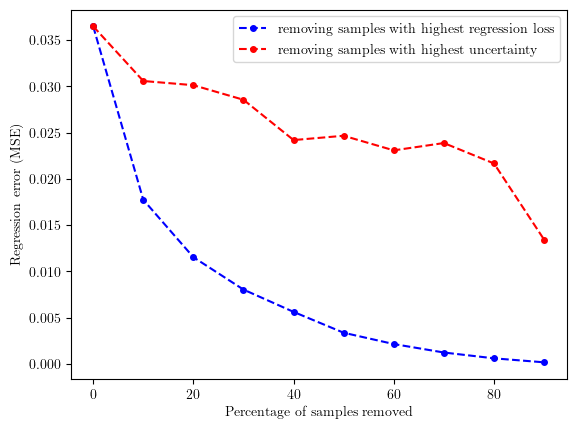

In [42]:
plt.plot(range(0, 100, 10), test_losses_loss, "bo--", label="removing samples with highest regression loss", markersize=4)
plt.plot(range(0, 100, 10), test_losses_uncertainty, "ro--", label="removing samples with highest uncertainty", markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")